In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import dask.dataframe as dd

In [2]:
# paths for the three dfs
df_jan_path = "../data/raw/yellow_tripdata_2016-01.csv"
df_feb_path = "../data/raw/yellow_tripdata_2016-02.csv"
df_mar_path = "../data/raw/yellow_tripdata_2016-03.csv"

# load the dataframes with optimized dtypes
dtypes = {
    'trip_distance': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'fare_amount': 'float32'
}

df_jan = dd.read_csv(df_jan_path, assume_missing=True, 
                     usecols=['trip_distance', 'pickup_longitude', 'pickup_latitude',
                             'dropoff_longitude', 'dropoff_latitude', 'fare_amount'],
                     dtype=dtypes)
df_feb = dd.read_csv(df_feb_path, assume_missing=True, 
                     usecols=['trip_distance', 'pickup_longitude', 'pickup_latitude',
                             'dropoff_longitude', 'dropoff_latitude', 'fare_amount'],
                     dtype=dtypes)
df_mar = dd.read_csv(df_mar_path, assume_missing=True, 
                     usecols=['trip_distance', 'pickup_longitude', 'pickup_latitude',
                             'dropoff_longitude', 'dropoff_latitude', 'fare_amount'],
                     dtype=dtypes)

In [3]:
# concat the three dataframes as one
df_final = dd.concat([df_jan, df_feb, df_mar], axis=0)

# New york bounding box coordinates
min_latitude = 40.60
max_latitude = 40.85
min_longitude = -74.05
max_longitude = -73.70

# Calculate percentiles using Dask (without loading into memory)
print("Calculating fare amount percentiles...")
fare_percentiles = df_final["fare_amount"].quantile([0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]).compute()
print("Fare amount percentiles:", fare_percentiles)

print("Calculating trip distance percentiles...")
trip_percentiles = df_final["trip_distance"].quantile([0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]).compute()
print("Trip distance percentiles:", trip_percentiles)

Calculating fare amount percentiles...
Fare amount percentiles: 0.991     52.0
0.992     52.0
0.993     52.0
0.994     52.5
0.995     56.0
0.996     60.0
0.997     65.5
0.998     73.0
0.999    100.0
Name: fare_amount, dtype: float64
Calculating trip distance percentiles...
Trip distance percentiles: 0.991    19.600000
0.992    19.600000
0.993    19.600000
0.994    19.799999
0.995    20.280001
0.996    20.799999
0.997    21.492100
0.998    22.600000
0.999    26.997190
Name: trip_distance, dtype: float64


In [4]:
# Set outlier thresholds
max_fare_amount_val = fare_percentiles.iloc[-2]  # 99.8th percentile
min_fare_amount_val = 0.50
print(f"Fare amount range: {min_fare_amount_val} to {max_fare_amount_val}")

min_trip_distance_val = 0.25
max_trip_distance_val = trip_percentiles.iloc[-2]  # 99.8th percentile
print(f"Trip distance range: {min_trip_distance_val} to {max_trip_distance_val}")

# Remove Outliers from the Data (all filtering done in Dask)
print("Filtering outliers...")
df_final = df_final.loc[
    (df_final["pickup_latitude"].between(min_latitude, max_latitude, inclusive="both")) & 
    (df_final["pickup_longitude"].between(min_longitude, max_longitude, inclusive="both")) & 
    (df_final["dropoff_latitude"].between(min_latitude, max_latitude, inclusive="both")) & 
    (df_final["dropoff_longitude"].between(min_longitude, max_longitude, inclusive="both")) &
    (df_final["fare_amount"].between(min_fare_amount_val, max_fare_amount_val, inclusive="both")) & 
    (df_final["trip_distance"].between(min_trip_distance_val, max_trip_distance_val, inclusive="both"))
]

# Check the filtered dataset size
print(f"Filtered dataset size: {len(df_final)} rows")

Fare amount range: 0.5 to 73.0
Trip distance range: 0.25 to 22.600000381469727
Filtering outliers...
Filtered dataset size: 33222751 rows


In [6]:
# Optional: Create boxplots with a sample of the data to avoid memory issues
print("Creating visualizations with sample data...")
# Use fraction instead of absolute number (0.01 = 1% of data)
sample_fraction = 0.01  # Adjust based on your memory (0.01 = 1%, 0.005 = 0.5%)
df_sample = df_final.sample(frac=sample_fraction, random_state=42).compute()

Creating visualizations with sample data...


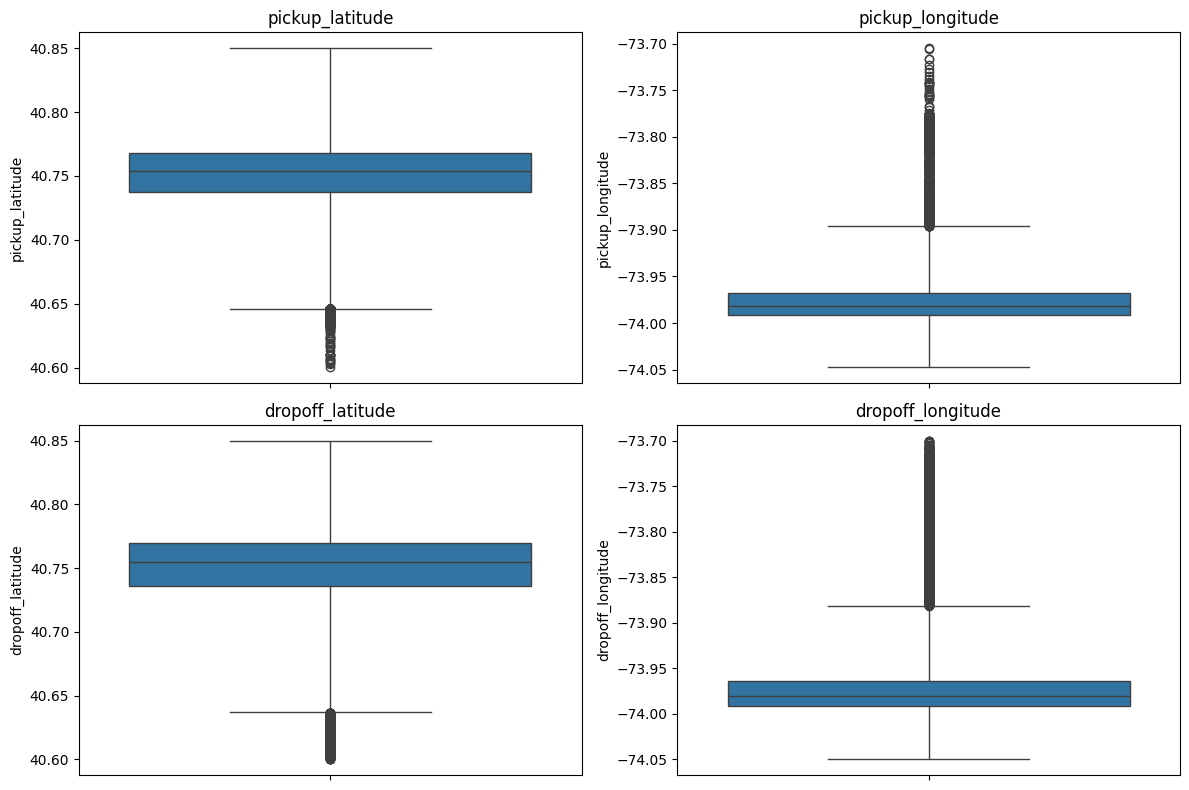

In [7]:
# Location Based Columns visualization
location_subset = df_sample[['pickup_latitude','pickup_longitude', 
                           'dropoff_latitude','dropoff_longitude']]

# boxplots for location based columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
axes = axes.flatten()

for i, col in enumerate(location_subset.columns):
    sns.boxplot(y=location_subset.iloc[:,i], ax=axes[i], whis=3)
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()

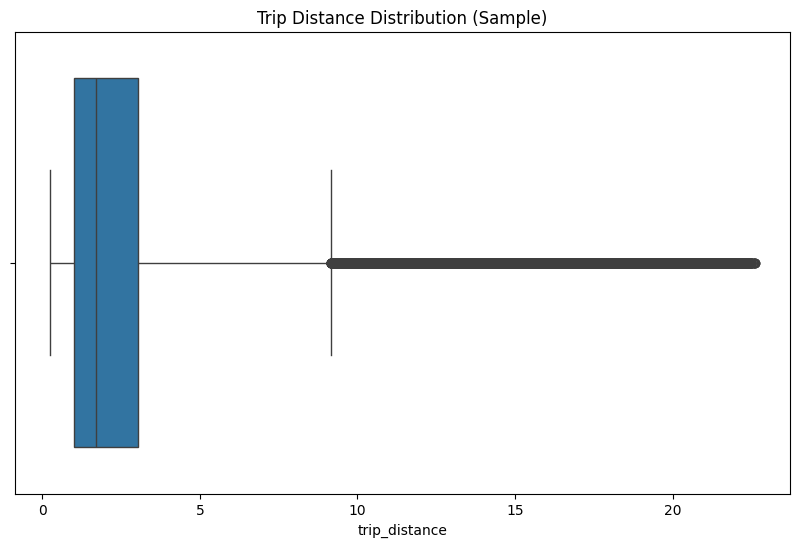

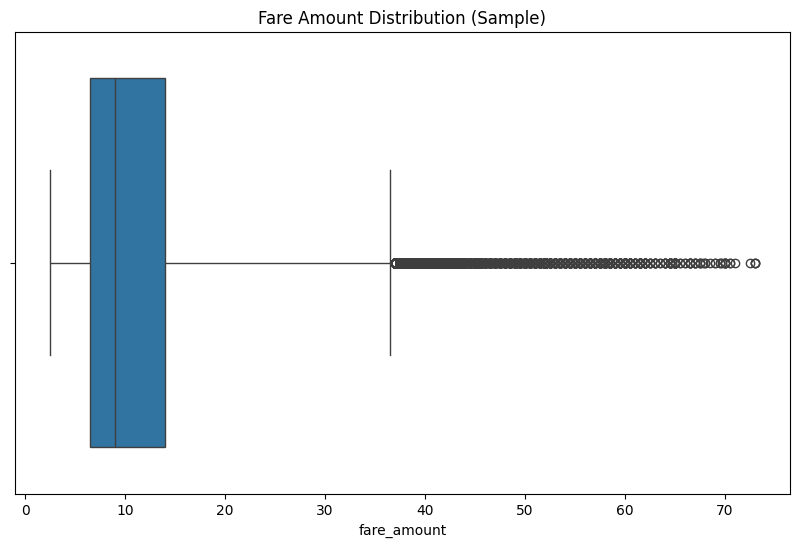

In [8]:
# boxplot for the trip distance
plt.figure(figsize=(10,6))
sns.boxplot(x=df_sample["trip_distance"], whis=3)
plt.title('Trip Distance Distribution (Sample)')
plt.show()

# boxplot for the fare amount
plt.figure(figsize=(10,6))
sns.boxplot(x=df_sample["fare_amount"], whis=3)
plt.title('Fare Amount Distribution (Sample)')
plt.show()

In [11]:
# Save the complete filtered dataset
save_path = "../data/interim/location_data.csv"
pickup_coord_dataset = df_final[['pickup_latitude','pickup_longitude']]

print("Saving complete filtered dataset...")
# Save the entire dataset using Dask (handles large files efficiently)
pickup_coord_dataset.to_csv(save_path, index=False, single_file=True)

# Get dataset info without loading everything into memory
print("Getting dataset information...")
total_partitions = pickup_coord_dataset.npartitions
print(f"Dataset has {total_partitions} partitions")

# Get approximate row count
row_count = len(pickup_coord_dataset)
print(f"Total rows in filtered dataset: {row_count:,}")

# Show a small sample for verification
print("\nSample of saved data:")
sample_coords = pickup_coord_dataset.sample(frac=0.001).compute()  # 0.1% sample
print(f"Sample shape: {sample_coords.shape}")
print(sample_coords.head())

print("Data processing complete!")

Saving complete filtered dataset...
Getting dataset information...
Dataset has 82 partitions
Total rows in filtered dataset: 33,222,751

Sample of saved data:
Sample shape: (33225, 2)
        pickup_latitude  pickup_longitude
388645        40.760410        -73.958527
167003        40.785759        -73.976501
205256        40.765644        -73.969948
12642         40.750313        -73.973816
97015         40.753033        -73.981041
Data processing complete!
